![title](https://pushkinmuseum.art/images/svg/logo_gmii.svg)

#### Соберем информацию о шедеврах, хранящихся в музее изобразительных искусств

In [234]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import tqdm
import cv2
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [2]:
base_url = "https://pushkinmuseum.art/"

In [3]:
# получить список ссылок с главной страницы
# на странице есть кнопка "показать еще", но она не подгружает картины, а просто делает их видимыми
def get_links():
    url = "https://pushkinmuseum.art/exposition_collection/collections/painting/index.php?lang=ru&rating=11441#objects"
    res = requests.get(url)
    main_page = res.content
    main_page = BeautifulSoup(main_page, 'html.parser')
    items = main_page.findAll("div", attrs={"class":"grid-item hides--grid-item"})
    return [el.findChild("img").parent.get("href") for el in items]

In [4]:
# найти целевое изображение на странице с картиной
def get_picture(page):
    a = page.find("a", attrs={"class":"js-call-dz"})
    return a.find("img").get("src")
    

In [21]:
# найти описание картины - название, автор, год создания
def get_details(page):
    picture_name = page.head.title.get_text()
    details = page.find("div", attrs={"class":"font-gmtext"})
    picture_author = re.sub("( ){2,}|\n|\(\?\)", "",details.h1.i.get_text()).strip()
    picture_date = details.findAll("i")[1].get_text()
#     практика показала, что описание есть не у всех картин
    try:
        picture_desc = page.find("div", attrs={"class":"text-main"}).p.get_text()
    except:
        picture_desc = None
    dct = {"picture_name":picture_name, 
           "picture_author":picture_author,
           "picture_date" :picture_date,
           "picture_desc":picture_desc
          }
    return dct

In [26]:
results = pd.DataFrame(columns=["picture_name", "picture_author", "picture_date", 
                                "picture_desc", "image"])
links = get_links()

In [27]:
# пробегаемся по всем ссылкам, загружаем информацию о картинах
for l in tqdm(links):
    try:
        res = requests.get(base_url+l)
        art_page = BeautifulSoup(res.content, 'html.parser')
        dct = get_details(art_page) 
        dct.update({"image":get_picture(art_page)})
        time.sleep(0.1)
        results = results.append(dct, ignore_index=True)
    except:
        print(base_url+l)
        

https://pushkinmuseum.art//data/fonds/europe_and_america/j/1001_2000/zh_171/index.php?lang=ru



In [34]:
# исправлям косяк разметки
results.picture_author = results.picture_author.str.replace("автор","")

In [35]:
results.to_excel("pictures.xlsx")

### Прекрасно, дасасет загружен. Посмотрим на него немножко

In [36]:
results.shape

(143, 5)

In [38]:
results.head()

,picture_name,picture_author,picture_date,picture_desc,image
0,Мадонна с младенцем на троне,Пизанский мастер третьей четверти XIII века,1270-е года,Икона представляет церковный алтарный образ. Д...,/data/fonds/europe_and_america/j/1001_2000/zh_...
1,Собор двенадцати апостолов,Константинопольский мастер начала XIV века,Начало XIV века,Этот памятник – один из шедевров живописи Пале...,/data/fonds/europe_and_america/j/1001_2000/zh_...
2,Великомученик и целитель Пантелеймон,Мастер Северной Греции (Фессалоники?) начала X...,Вторая половина XV века,Икона изображает одного из знаменитых святых в...,/data/fonds/europe_and_america/j/1001_2000/zh_...
3,Бичевание Христа,Иоганн Кербеке,До 1457,В ГМИИ с 1924 г. из Музея старины. Ранее – с к...,/data/fonds/europe_and_america/j/0000_1000/zh_...
4,Христос Пантократор,Константинопольский мастер (Ангелюс?) второй ч...,Вторая четверть XV века,Икона принадлежит к числу шедевров позднего ко...,/data/fonds/europe_and_america/j/1001_2000/zh_...


In [37]:
results.picture_author.value_counts()

Пабло Пикассо                                                   11
Рембрандт Харменс ван Рейн                                       4
Никола Пуссен                                                    3
Гвидо Рени                                                       3
Франсуа Буше                                                     3
                                                                ..
Адольф Фридрих Эрдман фон Менцель                                1
Гюбер Робер                                                      1
Джованни Антонио Каналь (Каналетто)                              1
Константинопольский мастер (Ангелюс?) второй четвертиXV века     1
Иоганн Кербеке                                                   1
Name: picture_author, Length: 112, dtype: int64

### Скачаем фотографии

In [41]:
import shutil
from pathlib import Path

In [76]:
photos_dir = Path.cwd() / "photo"
for link in results.image.values:
    image_path = photos_dir /  link[1:]
    image_path.parent.mkdir(parents=True, exist_ok=True)
    r = requests.get(base_url+link)
    out = open(str(image_path),'wb')
    out.write(r.content)
    out.close()
    time.sleep(0.1)

### попробуем сделать что-нибудь интересное

In [118]:
# загрузим в память наши шедевры
images = []
for link in results.image.values:
    image_path = photos_dir /  link[1:]
    img = cv2.imread(str(image_path))
    images.append(img)
    

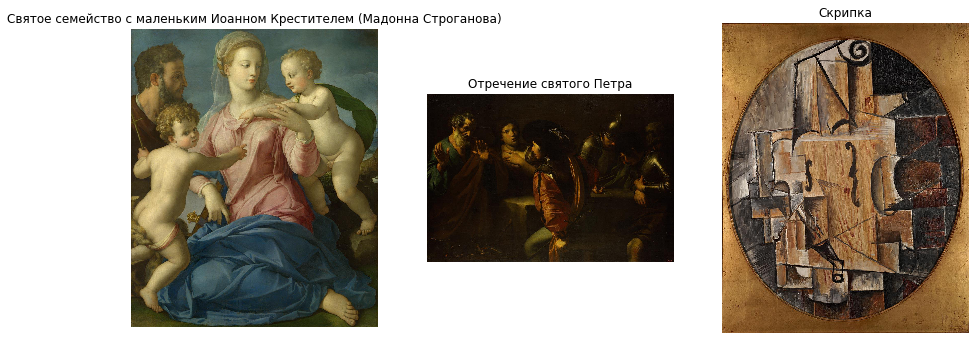

In [152]:
# Выведем несколько работ для вдохновения
fig, axs = plt.subplots(1,3, figsize=(15,10))

for i, img_index in enumerate(np.random.choice(range(len(images)),3)):
    axs[i].imshow(cv2.cvtColor(images[img_index], cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    axs[i].title.set_text(results.iloc[img_index].picture_name)
    


### Интересно, а насколько шедевры отличаются друг от друга по цветовой гамме?

In [173]:
# Построим гистограммы
hist_arr=[]
for img in images:
    color = ('b','g','r')
    h_list = []
    for i,col in enumerate(color):
        histr = cv2.calcHist([img],[i],None,[256],[0,256])
        histr = histr/histr.sum()
        h_list.append(histr.reshape(256))
    hist_arr.append(np.hstack(h_list))

In [196]:
# рассчитаем агрегаты по художникам
df_all = results.join(pd.DataFrame(np.array(hist_arr)))
hist_stat = \
df_all[df_all.picture_author.isin(
    ["Пабло Пикассо","Рембрандт Харменс ван Рейн"]
)].groupby(by="picture_author").mean().append(
df_all.mean().rename("Общее по галерее")
)

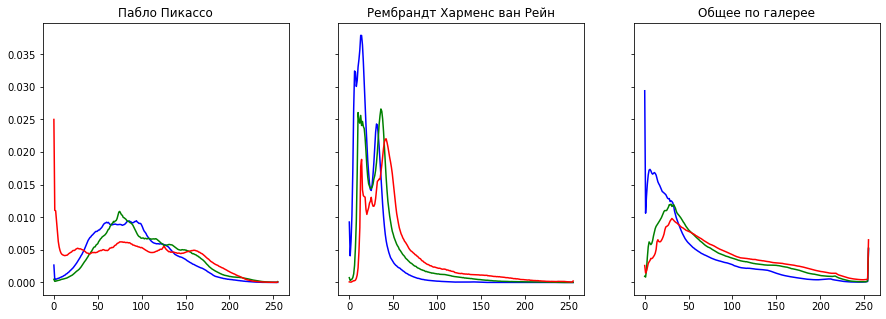

In [215]:
# посмотрим на на посчитанные агрегаты
fig, axs = plt.subplots(1,3, sharey= True, figsize=(15,5))
color = ('b','g','r')
for i, artist_name in enumerate(hist_stat.index):
    axs[i].title.set_text(artist_name)
    for c_i, col in enumerate(color):
        axs[i].plot(hist_stat.loc[artist_name].values.reshape(3,256)[c_i],color = col)


### Интересно, а можем ли мы найти "почерк" художника по его цветовым решениям?
#### (спойлер - можем. см. Пикассо)

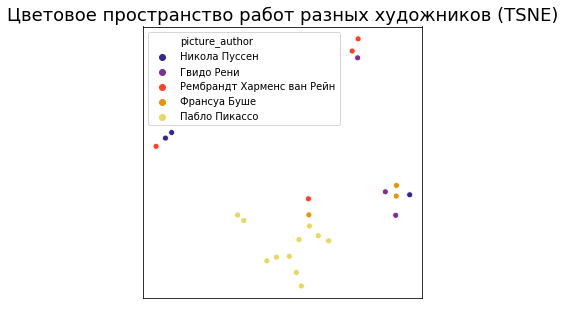

In [276]:
from sklearn.manifold import TSNE
df_short = df_all[df_all.picture_author.isin(df_all.picture_author.value_counts().head(5).index)]
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
tsne_transformed = tsne.fit_transform(df_short.iloc[:,5:])
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(
    x=tsne_transformed[:, 0], 
    y=tsne_transformed[:, 1], 
    hue=df_short.picture_author, 
    palette="CMRmap",
    legend='full'
)
plt.title("Цветовое пространство работ разных художников (TSNE)", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])
plt.show()

### Хмм, такие разные. Может быть поищем необычные цветовые решения?

In [278]:
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

In [296]:
pca = PCA(n_components=20)
transformed = pca.fit_transform(df_all.iloc[:,5:])
# pca.explained_variance_ratio_.sum()

In [297]:
one_class_svm = OneClassSVM(nu=0.03, gamma='auto')
one_class_svm.fit(transformed)
svm_outliers = one_class_svm.predict(transformed)
svm_outliers = np.array([1 if label == -1 else 0 for label in svm_outliers])

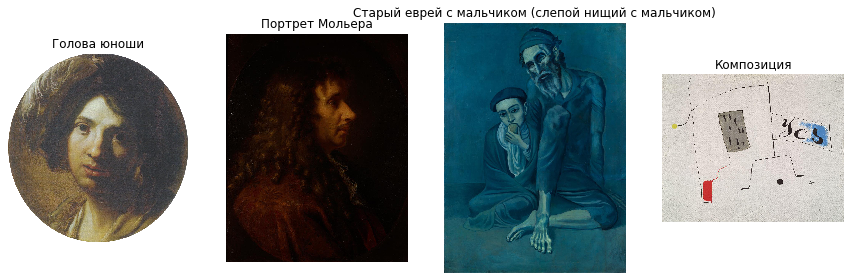

In [300]:
# Выведем несколько работ для вдохновения
fig, axs = plt.subplots(1,4, figsize=(15,10))

for i, img_index in enumerate(results[svm_outliers>0].index):
    axs[i].imshow(cv2.cvtColor(images[img_index], cv2.COLOR_BGR2RGB))
    axs[i].axis('off')
    axs[i].title.set_text(results.iloc[img_index].picture_name)

In [301]:
results[svm_outliers>0]

,picture_name,picture_author,picture_date,picture_desc,image
46,Голова юноши,Никола Ренье (Реньери),Между 1615-1620 годами,Тип лица модели и характер письма указывают на...,/data/fonds/europe_and_america/j/1001_2000/zh_...
57,Портрет Мольера,Шарль Лебрен,1660 - 1661,Портрет производит впечатление сделанного с на...,/data/fonds/europe_and_america/j/2001_3000/zh_...
132,Старый еврей с мальчиком (слепой нищий с мальч...,Пабло Пикассо,1903,Одним из центральных произведений голубого пер...,/data/fonds/europe_and_america/j/1001_2000/zh_...
141,Композиция,Хоан Миро,1927,Картина демонстрирует индивидуальный стиль худ...,/data/fonds/europe_and_america/j/1001_2000/zh_...


In [302]:
#### Спасибо за внимание